<a id="back_to_top"></a>
## Table of contents

This notebook has the following sections:
1. [Import Packages](#import_packages)
2. [Create DataFrames For Each Yelp Dataset](#create_dataframes)
3. [Data Storytelling](#storytelling)
4. [Keep All Above](#keep_above)
5. [Other Visualizations To Try](#other_visualizations)

Links to datasets:
https://drive.google.com/drive/folders/1J-jD0zZGult8XvIqVQQTfk5bb7vggVLo?usp=sharing

# Data Story:
- **Ask the following questions and look for the answers using code and plots:**
  - **Can you count something interesting?**
  - **Can you find trends (e.g. high, low, increasing, decreasing, anomalies)?**
  > any trends between:
  > - price cost vs. number of reviews?
  > - price cost vs. number of stars?
  > - number of reviews vs. attributes offered?
  > - number of tips vs. number of reviews?
  > - number of tips vs. stars?
  > - price cost vs. number of tips?
  > - photos vs tips, price, reviews
  - **Can you make a bar plot or a histogram?**
    - bar plot of value_counts for attributes
  - **Can you compare two related quantities?**
    - (see above)
  - **Can you make a scatterplot?**
    - bubble plot: number of reviews vs number of stars vs number of tips/attributes offered
    - checkin's over time
    - number of reviews per month
  - **Can you make a time-series plot?**
    - Reviews and tips over time
    - photos posted over time
    - types of photos posted over time
- **Looking at the plots, what are some insights you can make? Do you see any correlations? Is there a hypothesis you’d like to investigate further? What other questions do the insights lead you to ask?**
> - Is there any correlation between types of attributes offered and the business star rating or the amount of ratings, or the amount of stars per rating?
> - Hypothesis to test: If you have more attributes that match a Yelper's search, you will have more checkins, better ratings, more reviews, and more positive tips  posted.
> - Hypothesis to test: When you search for a category and attribute, the business with the most number of reviews and highest ratings will match what Yelp shows on their website.
- **Now that you’ve asked questions, hopefully you’ve found some interesting insights. Is there a narrative or a way of presenting the insights using text and plots that tells a compelling story? What are some other trends/relationships you think will make the story more complete?**
> Location, Location, Location: Is there anything about location that correlates to amount of reviews or amount of stars?

- Provide comments for each of the plots that I create

- **Current Issue:** It can often be very difficult to find a good restaurant, good mechanic, good barber shop, good cafe, etc. People can find a business on yelp and see their associated star rating but it’s hard to trust the star rating. Many times I find that people look at reviews and photos to determine if the business fits what they are looking for.
  - correlation between the positive words of the review and the Yelp rating?
  - correlation between the positive words of the tips and the Yelp rating?
  - plot of catgories and tops words used for tips
  - attributes: number of businesses with attribute "x"
  - businesses with attribute "x" ranked by number of 5-star reviews
  - businesses with attribute "x" but also multiple mentions in reviews/tips of related description with attribute
    - example: fast wifi, a lot of tables, good coffee, a lot of plugs, good place to study
  - businesses with attribute "x" plus "attribute "y" and close to a certain area
- **Problem to solve:** Is there a way to optimize searching for a business based on different features of photos (ambiance of business, food photo quality, etc.), review likes, keywords used in reviews, etc.

<a id="import_packages"></a>
[Back To Top](#back_to_top)
<div class="alert alert-block alert-danger">

## Import necessary packages
</div>

In [1]:
# Start with loading all necessary libraries
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

# Import file reading packages
import json
import ast

from itertools import chain, starmap

# Import Visualization Packages
import seaborn as sns
import matplotlib.pyplot as plt
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import folium
from folium import plugins

<div class="alert alert-block alert-danger">

## Methods to be used in analysis
</div>

In [2]:
def flatten_json_iterative_solution(dictionary):
    """Flatten a nested json file"""

    def unpack(parent_key, parent_value):
        """Unpack one level of nesting in json file"""
        # Unpack one level only!!!
        
        if isinstance(parent_value, dict):
            for key, value in parent_value.items():
                temp1 = parent_key + '_' + key
                yield temp1, value
        elif isinstance(parent_value, list):
            i = 0 
            for value in parent_value:
                temp2 = parent_key + '_'+str(i) 
                i += 1
                yield temp2, value
        else:
            yield parent_key, parent_value    

            
    # Keep iterating until the termination condition is satisfied
    while True:
        # Keep unpacking the json file until all values are atomic elements (not dictionary or list)
        dictionary = dict(chain.from_iterable(starmap(unpack, dictionary.items())))
        # Terminate condition: not any value in the json file is dictionary or list
        if not any(isinstance(value, dict) for value in dictionary.values()) and \
           not any(isinstance(value, list) for value in dictionary.values()):
            break

    return dictionary

In [3]:
# method to change string to another datatype, if necessary and if possible

def str_to_other(string):

    # Return a dictionary or list if string looks like a dictionary or list
    try:
        if isinstance(string, dict):
            dictionary = string
            return dictionary
        else:
            try:
                dictionary = ast.literal_eval(string)
                return dictionary
            except:
                pass
    except:
        pass

    # Return an integer if string looks like an integer
    try:
        integer = int(string)
        return integer
    except:
        pass

    # Return a float if string looks like a float
    try:
        number = float(string)
        return number

    # Return a bool if string looks like a bool
    except:
        if string =='True' or string == 'true':
            return True
        elif string == 'False' or string == 'false':
            return False
        elif isinstance(string, bool):
            return string

    # If none of the above, return original string
        else:
            return string

In [4]:
# Method to extract the column names of 

def columns_from_nested_dict(df_dict):

    set_keys = []
    temp_dict = str_to_other(df_dict)

    for key in temp_dict:
        value = str_to_other(temp_dict[key])
        if isinstance(value, dict):
            set_keys.append(key)
            sub_keys = list(columns_from_nested_dict(value))
            set_keys.append(sub_keys)
        else:
            pass
        set_keys.append(key)
    
    return set_keys

In [5]:
# Method to extract the keys and values of dict
def unpack_dict(df_dict):

    set_keys = []
    set_values = []
    temp_dict = str_to_other(df_dict)
    
    for key in temp_dict:
        if isinstance(temp_dict[key], bool):
            value = temp_dict[key]
        else:
            value = str_to_other(temp_dict[key])

        if isinstance(value, dict):
            unpack_dict(value)
        else:
            pass
        set_keys.append(key)
        set_values.append(value)
    
    return [set_keys, set_values]

In [6]:
## Method to determine count of positive and negative words used in the tips DataFrame per year, per month

def countSentimentPerMonth(positive_words, negative_words):

    positives = '|'.join(positive_words)

    negatives = '|'.join(negative_words)

    search_df = df_tip_subset.reset_index()

    search_df['year_month'] = search_df['datetime'].dt.strftime('%Y%m')

    positive_tip_count = search_df[search_df['text'].str.contains((positives).lower())]\
    .groupby(['year_month']).count().compliment_count

    negative_tip_count = search_df[search_df['text'].str.contains((negatives).lower())]\
    .groupby(['year_month']).count().compliment_count
    
    return [positive_tip_count, negative_tip_count]

In [7]:
## Method to determine count of positive and negative words used in the tips DataFrame per year, per month

def countSentimentPerBusiness(positive_words, negative_words):

    positives = '|'.join(positive_words)

    negatives = '|'.join(negative_words)

    search_df = df_tip_subset.reset_index()

    positive_tip_count = search_df[search_df['text'].str.contains((positives).lower())]\
    .groupby(['business_id']).count().compliment_count.sort_values(ascending = False)

    negative_tip_count = search_df[search_df['text'].str.contains((negatives).lower())]\
    .groupby(['business_id']).count().compliment_count.sort_values(ascending = False)
    
    return [positive_tip_count, negative_tip_count]

In [8]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

## Extract information from Yelp json files and convert to csv files

<a id="create_dataframes"></a>
[Back To Top](#back_to_top)
## Create pandas DataFrames from each of the Yelp datasets

In [9]:
csv_filepath = '/Users/jeromegonzaga/Documents/Bootcamp/Capstone Project #1_assets/yelp_dataset/'
csv_files = {'business':'business.csv', 'checkin':'checkin.csv', 'photo':'photo.csv',\
             'review':'review.csv', 'tip':'tip.csv', 'user':'user.csv'}

### *** Option 1 : Use more parts of the Yelp dataset & create subset DataFrames from original DataFrames

### *** Option 2: Only use a cleaned up subset of the Yelp dataset

In [10]:
%%time

# Code to only use a subset of the data (to run faster and over a smaller amount of data)
df_business_subset = pd.read_csv('/Users/jeromegonzaga/Documents/Bootcamp/Capstone Project #1_datastorytelling/business_clean.csv')
df_business_subset = df_business_subset.fillna('')

df_photo_subset  = pd.read_csv('/Users/jeromegonzaga/Documents/Bootcamp/Capstone Project #1_datastorytelling/photo_clean.csv', 
                               lineterminator='\n')
df_photo_subset = df_photo_subset.fillna('')

df_review_subset  = pd.read_csv('/Users/jeromegonzaga/Documents/Bootcamp/Capstone Project #1_datastorytelling/review_clean.csv')
df_review_subset = df_review_subset.fillna('')

df_tip_subset = pd.read_csv('/Users/jeromegonzaga/Documents/Bootcamp/Capstone Project #1_datastorytelling/tip_clean.csv')
df_tip_subset = df_tip_subset.fillna('')

df_checkin_subset = pd.read_csv('/Users/jeromegonzaga/Documents/Bootcamp/Capstone Project #1_datastorytelling/checkin_clean.csv')
df_checkin_subset = df_checkin_subset.fillna('')

df_user = pd.read_csv('/Users/jeromegonzaga/Documents/Bootcamp/Capstone Project #1_datastorytelling/user.csv', dtype = {'elite': str })
df_user = df_user.fillna('')

CPU times: user 48.3 s, sys: 6.87 s, total: 55.2 s
Wall time: 50.8 s


## Reformat date columns for some of the datasets

In [11]:
# Re-format 'date' column to proper 'datetime' format
time_format = '%Y-%m-%d %H:%M'
df_tip_subset['datetime'] = pd.to_datetime(df_tip_subset['date'], format = time_format)
df_review_subset['datetime'] = pd.to_datetime(df_review_subset['date'], format = time_format)

## Clean up the attributes in the df_business_subset DataFrame

In [12]:
# This finds the new column names

new_columns_attributes = []

for attribute in ['attributes', 'hours']:

    sub_columns = []

    column = df_business_subset.iloc[:][attribute].fillna('')

    for line in column:
        [column_names, data] = unpack_dict(line)
        sub_columns.append(column_names)

    sublist = [item for sublist in sub_columns for item in sublist]

    for i in sublist:
        if str(i) not in new_columns_attributes:
            new_columns_attributes.append(i)

In [13]:
for new_col in new_columns_attributes:
    df_business_subset[new_col] = ''

In [14]:
# This fills in df_business_subset from the information in the nested dictionaries

for x in range(df_business_subset.shape[0]):
    for attribute in ['attributes', 'hours']:

        temp_dict = df_business_subset.iloc[x][attribute]
        [column_names, data] = unpack_dict(temp_dict)
        
        column_names = [name for name in column_names]
        attribute_dict = dict(zip(column_names, data))
        for key in attribute_dict:
             df_business_subset.at[x, key] = attribute_dict[key]

In [15]:
# Re-write business CSV file with updated columns
business_clean_csv = df_business_subset.to_csv\
    (r'/Users/jeromegonzaga/Documents/Bootcamp/Capstone Project #1/business_clean.csv', index = None, header=True)

## Delete DataFrames no longer needed

## DataFrames available for use

- df_business_subset
- df_photo_subset
- df_review_subset
- df_tip_subset
- df_checkin_subset
- df_user

## Map of Businesses

The map below is a way to visualize where on the map each of the businesses in the yelp dataset are. This map will be useful later when analysis is done on how highly reviewed each of the businesses are compared to other businesses. The size of each of the "markers" for the business will change depending on the quality and quantity of the reviews, tips and business attributes.

In [16]:
df_map = df_business_subset[['business_id', 'latitude', 'longitude']].head(1000)

In [17]:
latitude = df_map.latitude.mean()
longitude = df_map.longitude.mean()

In [18]:
# create map and display it
business_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# instantiate a feature group for the incidents in the dataframe
businesses = folium.map.FeatureGroup()

# loop through the businesses and add each to the businesses feature group
for lat, lng, label, in zip(df_map.latitude, df_map.longitude, df_map.business_id):
    businesses.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=5, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.4,
            popup = label
        )
    )

# add incidents to map
business_map.add_child(businesses)

In [19]:
# let's start again with a clean copy of the map of San Francisco
businesses_map = folium.Map(location = [latitude, longitude], zoom_start = 11)

# instantiate a mark cluster object for the incidents in the dataframe
businesses = plugins.MarkerCluster().add_to(businesses_map)

# loop through the dataframe and add each data point to the mark cluster
for lat, lng, label, in zip(df_map.latitude, df_map.longitude, df_map.business_id):
    folium.Marker(
        location=[lat, lng],
        icon=None,
        popup=label,
    ).add_to(businesses)

# display map
businesses_map

## Get the attributes for each business

In [20]:
df_business_attributes = df_business_subset[['business_id', 'RestaurantsPriceRange2',
       'GoodForKids', 'BusinessAcceptsCreditCards', 'ByAppointmentOnly',
       'BikeParking', 'Ambience', 'HasTV', 'Music', 'RestaurantsGoodForGroups',
       'OutdoorSeating', 'RestaurantsReservations', 'BusinessParking',
       'Alcohol', 'NoiseLevel', 'GoodForDancing', 'HappyHour', 'GoodForMeal',
       'WiFi', 'RestaurantsAttire', 'Caters', 'RestaurantsTakeOut',
       'RestaurantsDelivery', 'HairSpecializesIn', 'WheelchairAccessible',
       'BusinessAcceptsBitcoin', 'Corkage', 'BYOBCorkage', 'BYOB',
       'RestaurantsTableService', 'DogsAllowed', 'AgesAllowed',
       'AcceptsInsurance', 'DriveThru', 'Smoking', 'CoatCheck', 'BestNights',
       'DietaryRestrictions', 'Open24Hours', 'RestaurantsCounterService']]
df_business_attributes = df_business_attributes.melt(id_vars = ['business_id'], var_name = 'attribute', 
                                                     value_name = 'value')
df_business_attributes = df_business_attributes[df_business_attributes['value']!='']
df_business_attributes = df_business_attributes.sort_values(by = 'business_id')

<a id="storytelling"></a>
[Back To Top](#back_to_top)
<div class="alert alert-block alert-danger">

# Data Story Telling
</div>

## Plot of WiFi

As a starter to visualize some fo the data in the datasets, the amount of businesses that provide Wifi and the number of businesses that are good for particular meals is plotted in the graphs below.

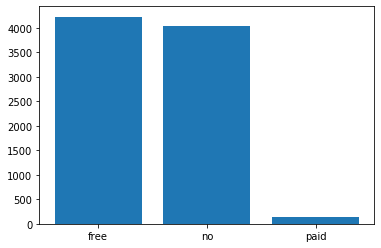

In [21]:
df_wifi = df_business_attributes.query("attribute == 'WiFi'")

y = pd.DataFrame(df_wifi.value.value_counts())['value']

plt.bar(x = y.index, height = y)
plt.show()


## Plot of GoodForMeals

In [22]:
df_GoodForMeal = df_business_attributes.query("attribute == 'GoodForMeal'")
df_GoodForMeal_reshaped = df_GoodForMeal.pivot(index = 'business_id',
                                                        columns = 'attribute')['value'].reset_index()
df_GoodForMeal_reshaped.columns.name = None
df_GoodForMeal_reshaped = df_GoodForMeal_reshaped.dropna()

In [23]:
# This finds the new column names

nested_attribute_name = ['GoodForMeal']
df_temp = df_GoodForMeal_reshaped

new_columns_attributes = []


for attribute in nested_attribute_name:

    sub_columns = []

    column = df_temp.iloc[:][attribute].fillna('')

    for line in column:
        [column_names, data] = unpack_dict(line)
        sub_columns.append(column_names)

    sublist = [item for sublist in sub_columns for item in sublist]

    for i in sublist:
        if str(i) not in new_columns_attributes:
            new_columns_attributes.append(i)

In [24]:
for new_col in new_columns_attributes:
    df_temp[new_col] = ''

In [25]:
# This fills in df_business_subset from the information in the nested dictionaries

for x in range(df_temp.shape[0]):
    for attribute in nested_attribute_name:

        temp_dict = df_temp.iloc[x][attribute]
        [column_names, data] = unpack_dict(temp_dict)
        
        column_names = [name for name in column_names]
        attribute_dict = dict(zip(column_names, data))
        for key in attribute_dict:
             df_temp.at[x, key] = attribute_dict[key]

df_GoodForMeal_reshaped = df_temp
df_GoodForMeal = df_GoodForMeal_reshaped[['business_id', 'dessert', 'latenight', 'lunch', 'dinner',
                                                  'brunch', 'breakfast']]

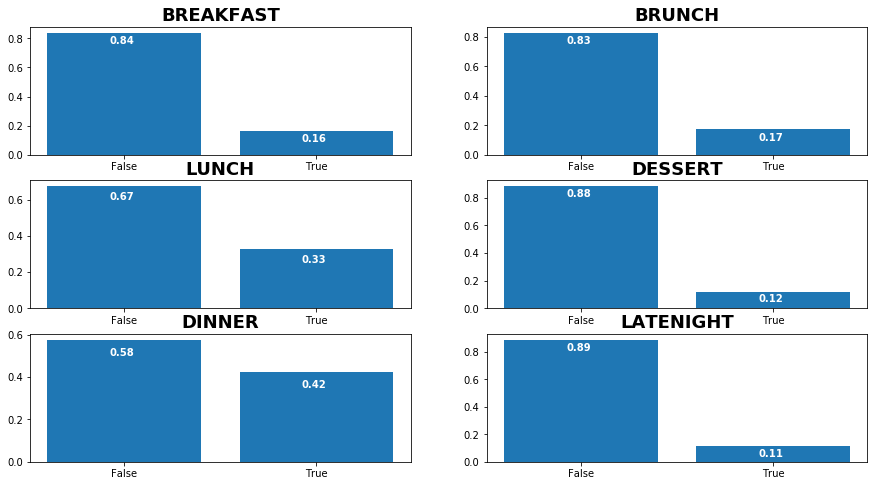

In [26]:
def plotMealBar(axis, meal):
    y = df_GoodForMeal[df_GoodForMeal[meal]!=''][meal].value_counts(normalize = True)

    axis.bar(x = ['False', 'True'], height = y)
    axis.set_title(meal.upper(), fontsize = 18, fontweight = 'bold')

    # create a list to collect the plt.patches data
    totals = []

    # find the values and append to list
    for i in axis.patches:
        totals.append(i.get_height())

    # set individual bar lables using above list
    total = sum(totals)

    # set individual bar lables using above list
    for i in axis.patches:
        # get_x pulls left or right; get_height pushes up or down
        axis.text(i.get_x()+.325, i.get_height()-0.075, \
                str(round(i.get_height(),2)), fontsize=10,
                    color='white', fontweight = 'bold')

fig, axs = plt.subplots(3, 2, figsize=(15,8))


axis = axs[0,0]
meal = 'breakfast'
plotMealBar(axis, meal)


axis = axs[1,0]
meal = 'lunch'
plotMealBar(axis, meal)


axis = axs[2,0]
meal = 'dinner'
plotMealBar(axis, meal)


axis = axs[0,1]
meal = 'brunch'
plotMealBar(axis, meal)


axis = axs[1,1]
meal = 'dessert'
plotMealBar(axis, meal)


axis = axs[2,1]
meal = 'latenight'
plotMealBar(axis, meal)

plt.show()

The plot above for the number of businesses good for particular meals is interesting to see as the plot shows that there are particular meals that businesses advertize on Yelp.

## Plot of the checkins for a business over time

THis plot of the checkins for a business over time is very interesting to visualize because you can see the sort of trends that some businesses have over time. Some businesses seem to receive a lot of check-ins at a particular time or have a steady check-in growth while others have a slower growth or no growth at all.

/Users/jeromegonzaga/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


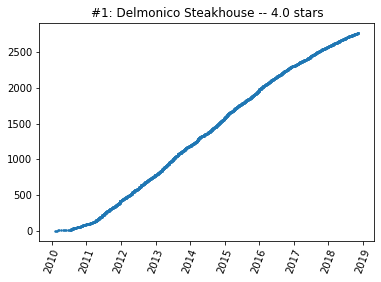

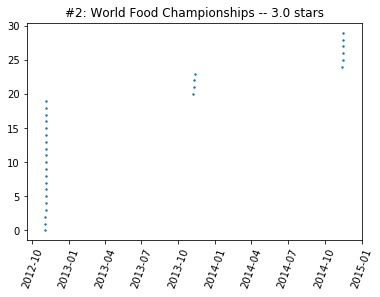

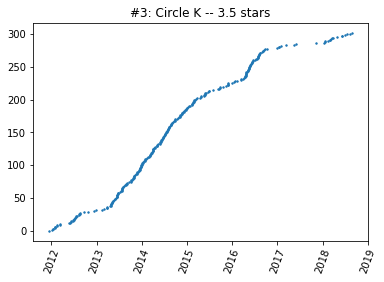

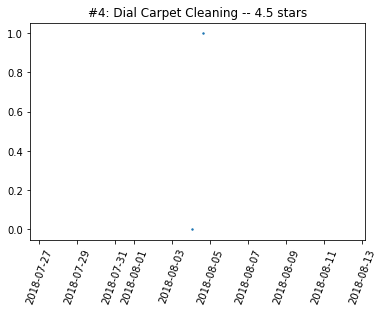

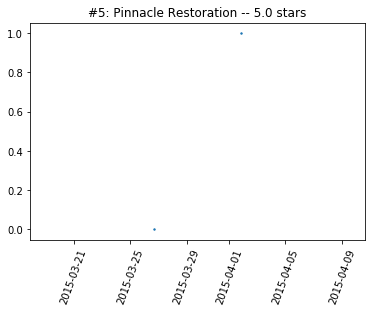

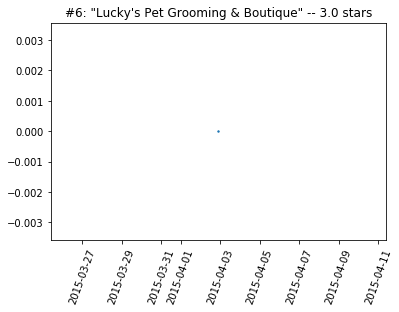

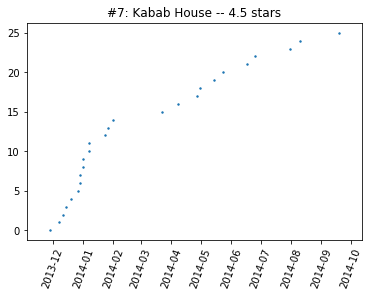

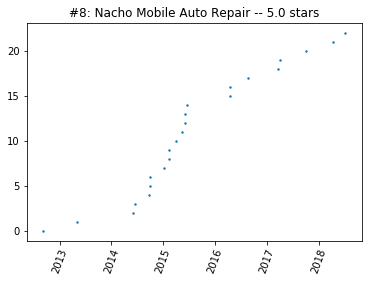

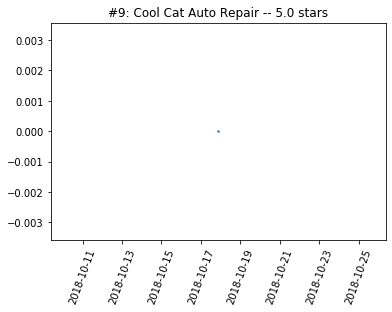

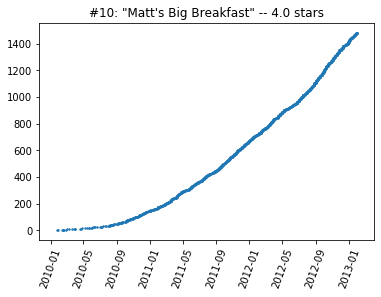

In [27]:
list_business_checkins = df_checkin_subset['business_id'].drop_duplicates()

num_businesses = 10

for business_number in range(num_businesses):

    df_checkin_test = df_checkin_subset[df_checkin_subset['business_id']==list_business_checkins[business_number]]

    df1 = pd.DataFrame(df_checkin_test.business_id).reset_index()
    df2 = pd.DataFrame(df_checkin_test.date.str.split(',').tolist()).reset_index()

    df_checkin_test_1 = pd.concat([df1, df2], axis = 1).drop('index', axis = 1).\
        melt(id_vars = 'business_id', var_name = 'checkin', value_name = 'date').drop('checkin', axis = 1)

    df_checkin_test_1['datetime'] = df_checkin_test_1['date'].apply(lambda s:pd.to_datetime(s))

    plt.scatter(x = df_checkin_test_1['datetime'], y = range(df_checkin_test_1.shape[0]),
                data = df_checkin_test_1, s = 2)
    plt.title('#' + str(business_number + 1) + ': ' + str(list(df_business_subset.name[df_business_subset.\
          business_id==list_business_checkins[business_number]])).strip("'[]'") + ' -- ' + \
          str(list(df_business_subset.stars[df_business_subset.business_id==list_business_checkins[business_number]]))\
         .strip("'[]'") + ' stars')
    plt.xticks(rotation = 70)
    plt.show()

## Plot of number of reviews over time

In a similar fashion to the number of check-ins over time, this particular data for the number of reviews over time for a business is quite revealing for the business and how popular amoungst "yelpers" the business is.

In [28]:
df_review_subset['year_month'] = df_review_subset['datetime'].dt.strftime('%Y%m')
df_review_frequency = df_review_subset[['business_id', 'review_id', 'user_id', 'stars', 'useful', 'funny', 
                                       'cool', 'text', 'year_month']]

In [29]:
num_businesses = 5

top_reviewed_businesses = list(df_review_frequency.groupby('business_id').count().\
    sort_values(by='review_id', ascending = False).head(num_businesses).index)

In [30]:
business_id_list = list(df_review_frequency['business_id'].drop_duplicates())

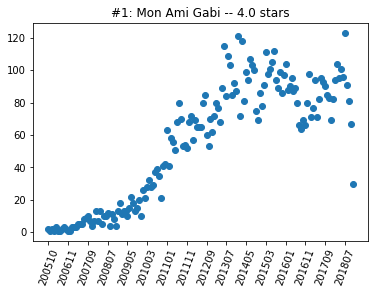

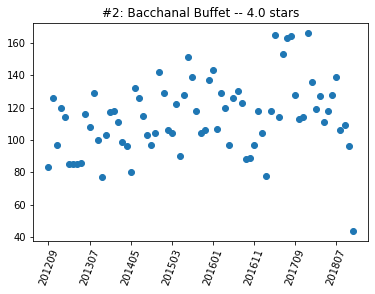

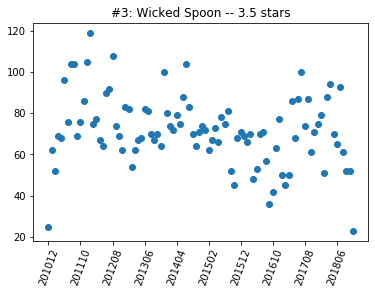

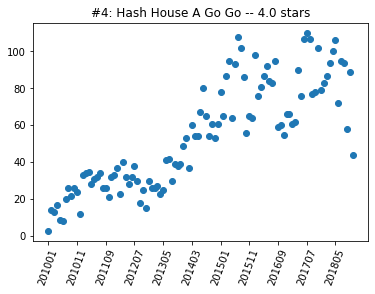

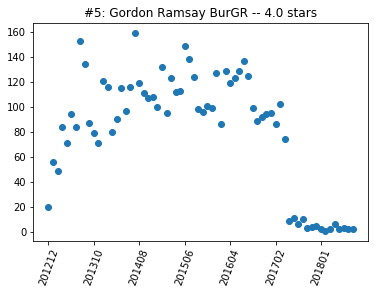

In [31]:
# plotting number of reviews over time for the top 50 businesses with the most reviews
for i in range(num_businesses):
    df_ind_business = df_review_frequency[df_review_frequency['business_id']==top_reviewed_businesses[i]].\
        sort_values(by = 'year_month', ascending = True)

    plt.scatter(x = df_ind_business.groupby('year_month').count().index, 
                y = df_ind_business.groupby('year_month').count().review_id)
    dates = list(df_ind_business.year_month.drop_duplicates())
    dates[::10]
    plt.xticks(dates[::10], rotation = 70)
    plt.title('#' + str(i + 1) + ': ' + str(list(df_business_subset.name[df_business_subset.\
              business_id==top_reviewed_businesses[i]])).strip("'[]'") + ' -- ' + \
              str(list(df_business_subset.stars[df_business_subset.business_id==top_reviewed_businesses[i]]))\
             .strip("'[]'") + ' stars')
    plt.show()

## Plot of use of negative & positive words over time for all businesses

As a way to experiment other visualizations, the "positivity" and "negativity" of business tips over time is shown below. This data was interesting to visualize as it shows the amount of "positive" or "negative" words used for the tips to other Yelpers for businesses. This data will be interesting to dive into further throughout the capstone project. The positivity of the words used for particular businesses was also explored.

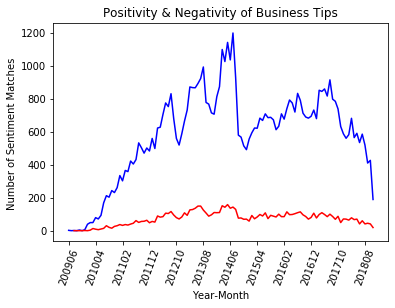

In [32]:
plt.clf()

positive_words = ['awesome','good','nice','super','fun','delightful']
negative_words = ['awful','lame','horrible','bad', 'disgusting', 'terrible']

[positive_tip_count, negative_tip_count] = countSentimentPerMonth(positive_words, negative_words)

plt.plot(positive_tip_count, color = 'blue')
plt.plot(negative_tip_count, color = 'red')

plt.xlabel('Year-Month')

dates = list(pd.DataFrame(positive_tip_count).index.drop_duplicates())
dates[::10]
plt.xticks(dates[::10], rotation = 70)

# plt.xticks(rotation=90)
plt.ylabel('Number of Sentiment Matches ')
plt.title('Positivity & Negativity of Business Tips')
plt.show()

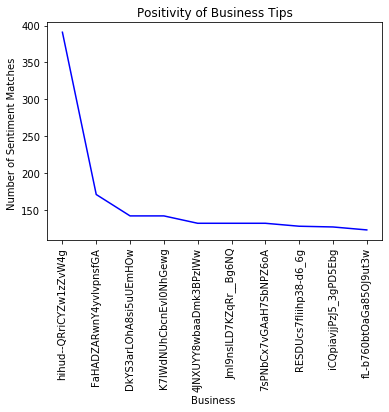

In [33]:
plt.clf()

positive_words = ['awesome','good', 'nice','super','fun','delightful']
negative_words = ['awful','lame','horrible','bad', 'disgusting', 'terrible']

[positive_tip_count, negative_tip_count] = countSentimentPerBusiness(positive_words, negative_words)

plt.plot(positive_tip_count.head(10), color = 'blue')
# plt.plot(negative_tip_count.head(10), color = 'red')

plt.xlabel('Business ')
plt.xticks(rotation=90)
plt.ylabel('Number of Sentiment Matches ')
plt.title('Positivity of Business Tips')
plt.show()

## Plot of categories and top words used in tips

Visualizing the amount of businesses per category available on Yelp was revealing as it showed the popular type of businesses that are available for Yelpers to see on Yelp.

In [34]:
categories_dict = {}
for row in range(df_business_subset.shape[0]):
    categories_row = df_business_subset.categories[row]
    categories_list = categories_row.strip('][').split(', ')
    
    for item in categories_list:
        if item in categories_dict.keys():
            categories_dict[item] += 1
        else:
            categories_dict[item] = 1

df_categories = pd.DataFrame(list(categories_dict.items()),
                             index = range(len(list(categories_dict.items()))))
df_categories.columns = ['category', 'count']

In [35]:
df_categories_subset = df_categories.sort_values(by = 'count', ascending = False).set_index('category').head(20)

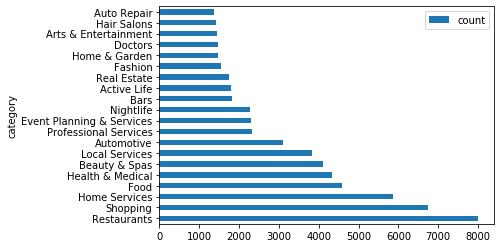

In [36]:
df_categories_subset.plot.barh(rot = 0)
plt.show()

## Plot of number of reviews versus price range versus yelp rating

The next series of plots for the numer of reviews for a particular category of business versus the price range and the yelp rating was interesting to visualize as well. The visualizations show the density or number of reviews for businesses with particular ratings and price ranges. The visualizations seem to suggest that there are more reviews given to businesses with mid-price ranges and yelp ratings 2.5 and 4.5. One would think that more reviews would be given to businesses with higher ratings but the data seems to suggest otherwise.

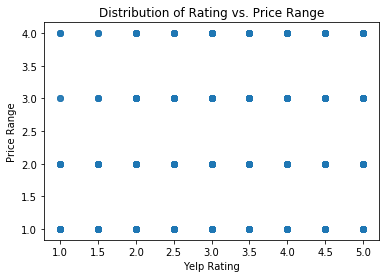

In [37]:
# price cost vs. number of stars vs. number of reviews
df_cost_stars = df_business_subset[['business_id', 'RestaurantsPriceRange2', 'stars', 'review_count']].\
loc[(df_business_subset['is_open']==1) & (df_business_subset['RestaurantsPriceRange2']!='')]

N = df_cost_stars['stars'].shape[0]
review_count = df_cost_stars['review_count']
y = df_cost_stars['RestaurantsPriceRange2']
x = df_cost_stars['stars']
plt.xlabel('Yelp Rating')
plt.ylabel('Price Range')
plt.title('Distribution of Rating vs. Price Range')
colors = np.random.rand(N)

plt.scatter(x, y, marker = 'o', alpha = 0.25)
plt.show()

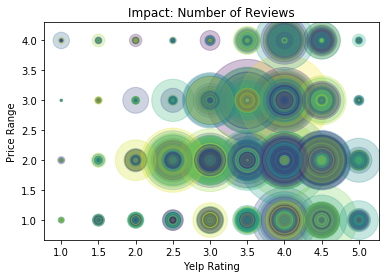

In [38]:
# price cost vs. number of stars vs. number of reviews
df_cost_stars = df_business_subset[['business_id', 'RestaurantsPriceRange2', 'stars', 'review_count']].\
loc[(df_business_subset['is_open']==1) & (df_business_subset['RestaurantsPriceRange2']!='')]

N = df_cost_stars['stars'].shape[0]
review_count = df_cost_stars['review_count']
y = df_cost_stars['RestaurantsPriceRange2']
x = df_cost_stars['stars']
plt.xlabel('Yelp Rating')
plt.ylabel('Price Range')
plt.title('Impact: Number of Reviews')
colors = np.random.rand(N)

plt.scatter(x, y, s = review_count, marker = 'o', alpha = 0.25, c = colors)
plt.show()

In [39]:
# number of tips vs. number of reviews
tips_count = df_tip_subset.reset_index().groupby('business_id').count().sort_values(by='user_id', ascending = False)['user_id'].reset_index()

In [40]:
reviews_count = df_review_subset.groupby('business_id').count().sort_values(by='review_id', ascending = False)['review_id'].reset_index()

In [41]:
tip_review_count = tips_count.set_index('business_id').join(reviews_count.set_index('business_id'),on='business_id')
tip_review_count.rename(columns = {'user_id':'tip_count', 'review_id':'review_count'}, inplace = True)
tip_review_count = tip_review_count.sort_values(by = 'review_count')

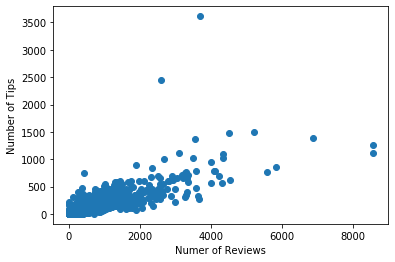

In [42]:
plt.scatter(tip_review_count['review_count'],tip_review_count['tip_count'])

plt.xlabel('Numer of Reviews')
plt.ylabel('Number of Tips')
plt.show()

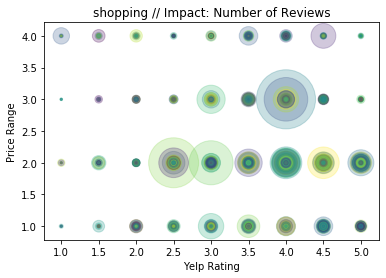

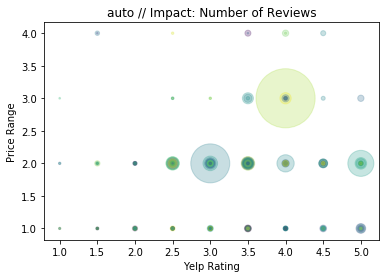

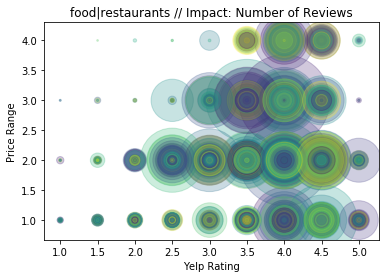

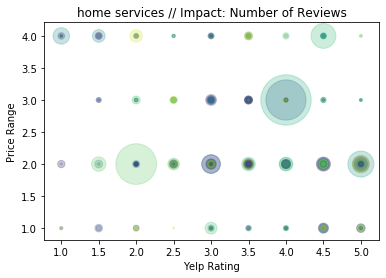

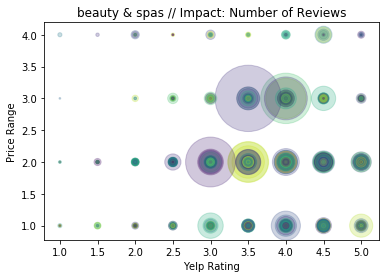

In [43]:
# price cost vs. number of stars vs. number of reviews
categories = [['shopping'],['auto'],['food', 'restaurants'],['home services'],['beauty & spas']]

for subcategories in categories:
    subcategories = '|'.join(subcategories)

    df_cost_stars = df_business_subset[['business_id', 'RestaurantsPriceRange2', 'stars', 'review_count']].\
    loc[df_business_subset['categories'].str.lower().str.contains(subcategories.lower()) &
        (df_business_subset['is_open']==1) & (df_business_subset['RestaurantsPriceRange2']!='')]

    N = df_cost_stars['stars'].shape[0]
    review_count = df_cost_stars['review_count']

    x = df_cost_stars['stars']
    y = df_cost_stars['RestaurantsPriceRange2']

    plt.xlabel('Yelp Rating')
    plt.ylabel('Price Range')
    plt.title(str(subcategories) + ' // Impact: Number of Reviews')
    colors = np.random.rand(N)

    plt.scatter(x, y, s = review_count, marker = 'o', alpha = 0.25, c = colors)
    plt.show()

## Pairplot of df_business_subset DataFrame

This pairplot of the business attributes was an example of plotting different attributes against one another just to see if there are any particular trends that intrestingly pop out of the data. There isn't any particular pairing of data that looks particularly interesting as of right now.

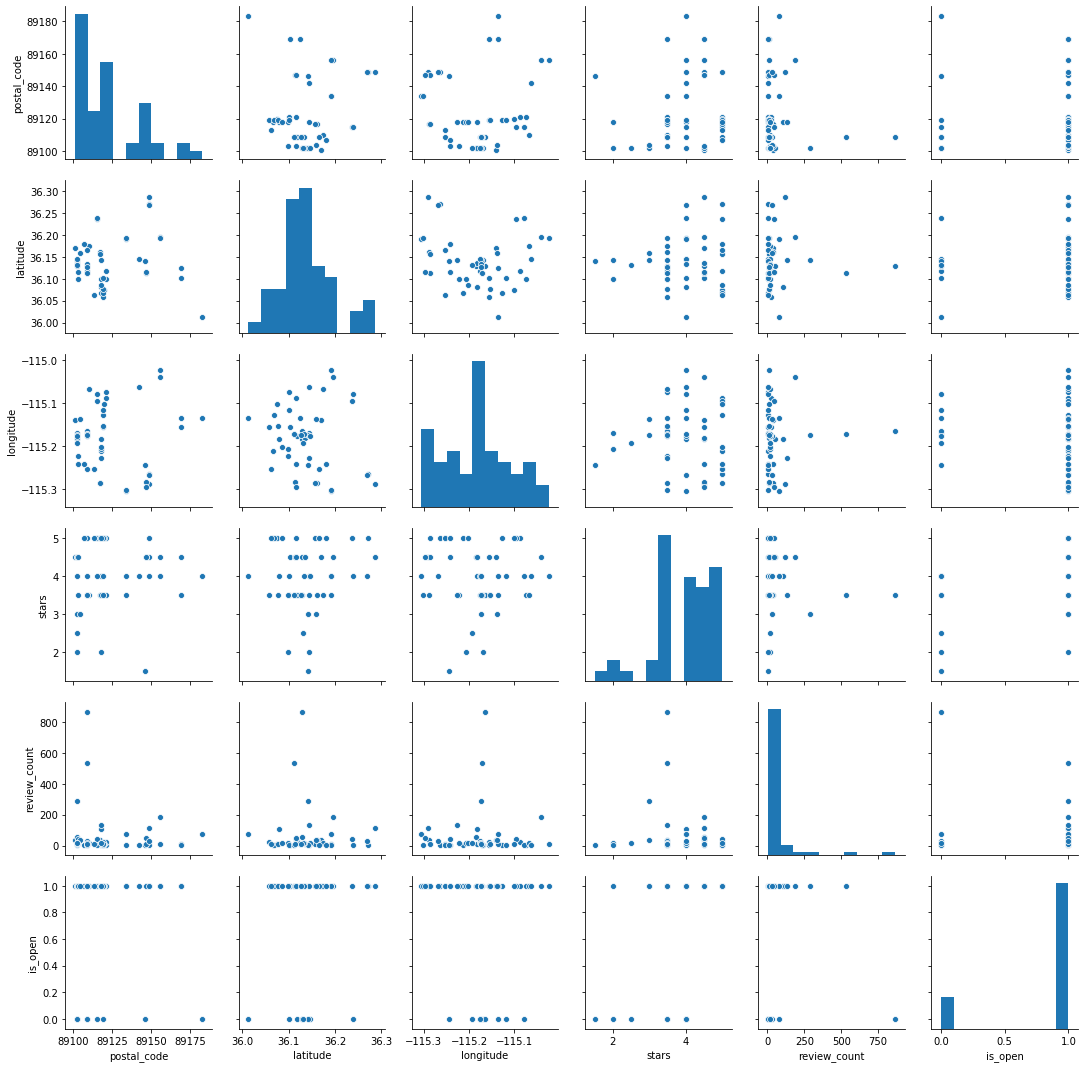

In [44]:
sns.pairplot(df_business_subset.head(50))

## Plot of Reviews per Rating per Business

The plots below for the number of reviews per rating per business is useful to see the distribution of the ratings for a particular business. This visualization and comparision will be interesting to dive further into later in the capstone project!

In [45]:
reviews_per_rating = df_review_subset.groupby(['business_id', 'stars']).\
    count().reset_index('stars')

reviews_per_rating.head()

stars  review_id  user_id  useful  funny  cool  text  \
business_id                                                                   
--9e1ONYQuAa-CB_Rrw7Tw     1         51       51      51     51    51    51   
--9e1ONYQuAa-CB_Rrw7Tw     2        144      144     144    144   144   144   
--9e1ONYQuAa-CB_Rrw7Tw     3        189      189     189    189   189   189   
--9e1ONYQuAa-CB_Rrw7Tw     4        438      438     438    438   438   438   
--9e1ONYQuAa-CB_Rrw7Tw     5        839      839     839    839   839   839   

                        date  datetime  year_month  
business_id                                         
--9e1ONYQuAa-CB_Rrw7Tw    51        51          51  
--9e1ONYQuAa-CB_Rrw7Tw   144       144         144  
--9e1ONYQuAa-CB_Rrw7Tw   189       189         189  
--9e1ONYQuAa-CB_Rrw7Tw   438       438         438  
--9e1ONYQuAa-CB_Rrw7Tw   839       839         839

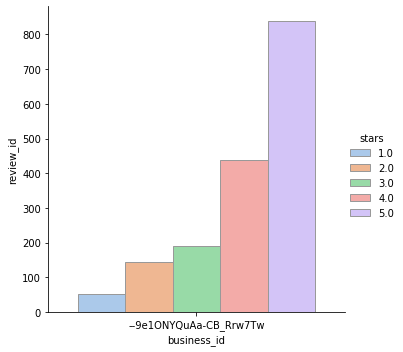

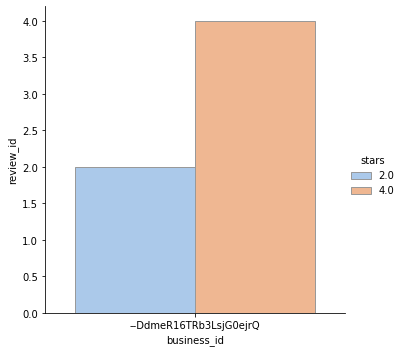

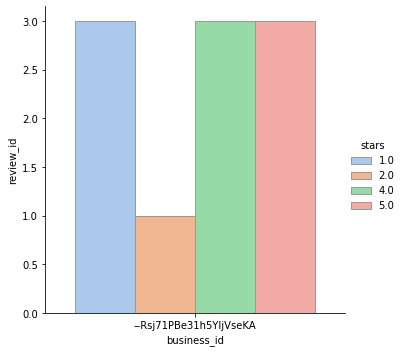

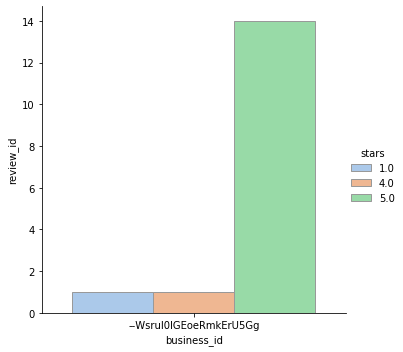

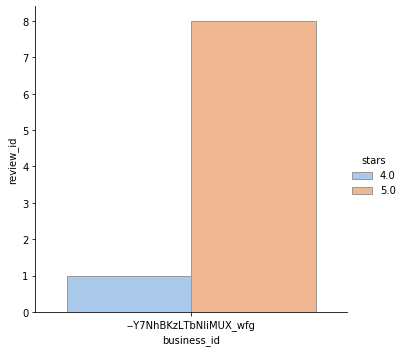

In [46]:
business_IDs = reviews_per_rating.reset_index().groupby('business_id').count().index

for i in range(5):
    sns.catplot(x = 'business_id', y = 'review_id', hue = 'stars', kind = 'bar', palette = 'pastel',
                edgecolor = '0.6', data = reviews_per_rating.loc[business_IDs[i]].reset_index())

In [47]:
reviews_per_rating.head()

stars  review_id  user_id  useful  funny  cool  text  \
business_id                                                                   
--9e1ONYQuAa-CB_Rrw7Tw     1         51       51      51     51    51    51   
--9e1ONYQuAa-CB_Rrw7Tw     2        144      144     144    144   144   144   
--9e1ONYQuAa-CB_Rrw7Tw     3        189      189     189    189   189   189   
--9e1ONYQuAa-CB_Rrw7Tw     4        438      438     438    438   438   438   
--9e1ONYQuAa-CB_Rrw7Tw     5        839      839     839    839   839   839   

                        date  datetime  year_month  
business_id                                         
--9e1ONYQuAa-CB_Rrw7Tw    51        51          51  
--9e1ONYQuAa-CB_Rrw7Tw   144       144         144  
--9e1ONYQuAa-CB_Rrw7Tw   189       189         189  
--9e1ONYQuAa-CB_Rrw7Tw   438       438         438  
--9e1ONYQuAa-CB_Rrw7Tw   839       839         839

## WordCloud used to determine most frequent customer tips for restaurants

The following WordClouds are fun visualizations performed as a way to confirm some of the trends seen for a particular category and to see what kind of attributes yelpers look for when it comes to businesses. These WordClouds are revealing of the words that are used more frequently than other words in yelper reviews. This information will be useful later in the capstone project to start to distinguish certain businesses over others.

In [48]:
category_list = ['Restaurants', 'Food']
categories = '|'.join(category_list)

business_restaurants = df_business_subset[df_business_subset.categories.str.contains(categories)].business_id

In [49]:
df_tip_subset = df_tip_subset.set_index('business_id')

In [50]:
df_restaurants = df_tip_subset.loc[business_restaurants]

/Users/jeromegonzaga/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


In [51]:
restaurants_text = ' '.join(str(review) for review in df_restaurants.text)
    
lower_restaurants_text = restaurants_text.lower()

<Figure size 432x288 with 0 Axes>

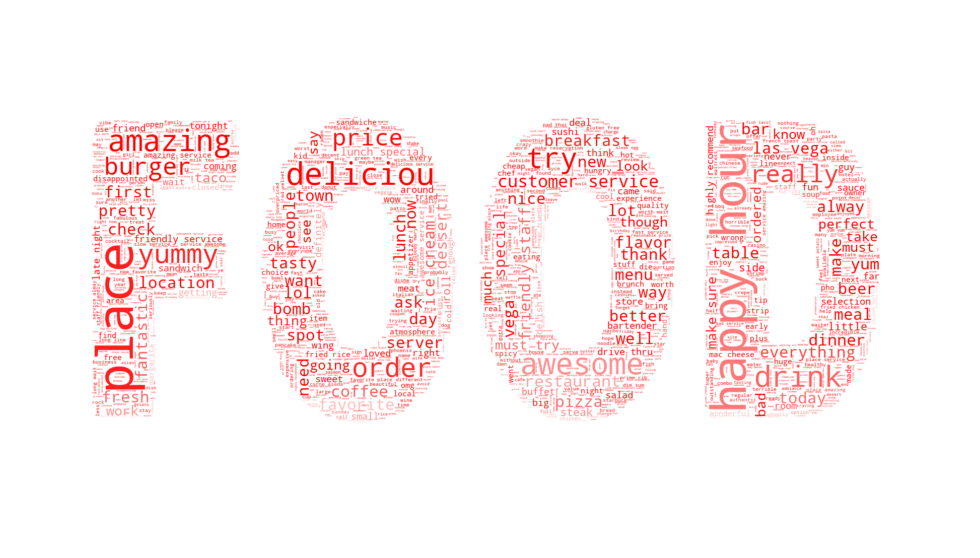

In [52]:
plt.clf()

# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(['love', 'two', 'best', 'great', 'good', 'one', 'week', 'back', 'will', 'go', 'come', 
                  'time', 'got', 'ur', 'food', 'still', 'excellent', 'even', 'eat', 'taste'])

# Generate a word cloud image
mask = np.array(Image.open('/Users/jeromegonzaga/Documents/Bootcamp/Capstone Project #1_assets/food.png'))
wordcloud = WordCloud(stopwords=stopwords, background_color="white", mode="RGBA", 
                      max_font_size = 100, max_words=5000, mask=mask).generate(lower_restaurants_text)

# create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[25,10])
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis('off')

plt.show()

## WordCloud used to determine most frequent customer tips for Automotive

In [53]:
category_list = ['auto']
categories = '|'.join(category_list)

business_restaurants = df_business_subset.loc[df_business_subset['categories'].str.lower().str.\
                       contains(categories.lower()) & (df_business_subset['is_open']==1)].business_id

In [54]:
df_restaurants = df_tip_subset.loc[business_restaurants]

/Users/jeromegonzaga/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


In [55]:
restaurants_text = ' '.join(str(review) for review in df_restaurants.text)
    
lower_restaurants_text = restaurants_text.lower()

<Figure size 432x288 with 0 Axes>

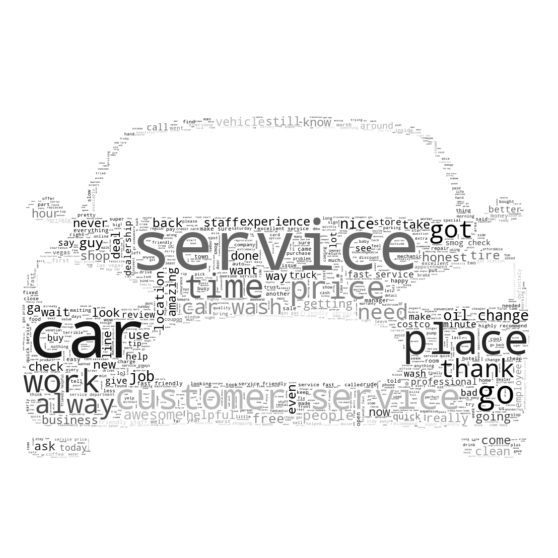

In [56]:
plt.clf()

# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(['love', 'nan', 'great', 'best', 'good', 'one', 'will', 'guy', 'day'])

# Generate a word cloud image
mask = np.array(Image.open('/Users/jeromegonzaga/Documents/Bootcamp/Capstone Project #1_assets/car.png'))
wordcloud = WordCloud(stopwords=stopwords, background_color="white", mode="RGBA", 
                      max_font_size = 200, max_words=2000, mask=mask).generate(lower_restaurants_text)

# create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[25,10])
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis('off')

plt.show()

## WordCloud used to determine most frequent customer tips for Home Services

In [57]:
category_list = ['home services']
categories = '|'.join(category_list)

business_restaurants = df_business_subset.loc[df_business_subset['categories'].str.lower().str.\
                       contains(categories.lower()) & (df_business_subset['is_open']==1)].business_id

In [58]:
df_restaurants = df_tip_subset.loc[business_restaurants]

/Users/jeromegonzaga/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


In [59]:
restaurants_text = ' '.join(str(review) for review in df_restaurants.text)
    
lower_restaurants_text = restaurants_text.lower()

<Figure size 432x288 with 0 Axes>

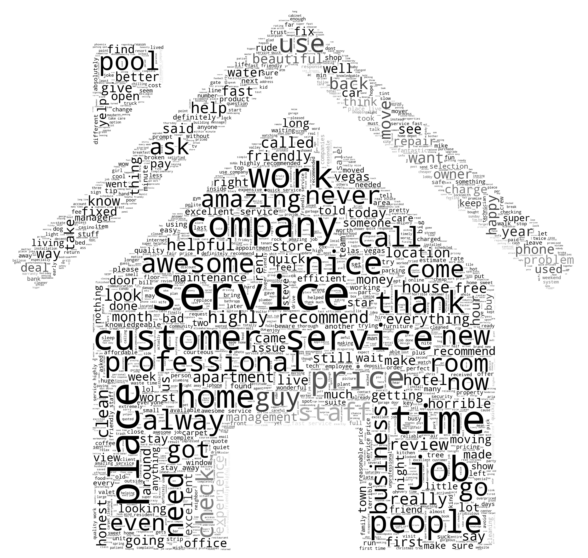

In [60]:
plt.clf()

# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(['love', 'nan', 'great', 'best', 'good', 'one', 'will', 'guy', 'day'])

# Generate a word cloud image
mask = np.array(Image.open('/Users/jeromegonzaga/Documents/Bootcamp/Capstone Project #1_assets/home.png'))
wordcloud = WordCloud(stopwords=stopwords, background_color="white", mode="RGBA", 
                      max_font_size = 200, max_words=2000, mask=mask).generate(lower_restaurants_text)

# create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[25,10])
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis('off')

plt.show()

## WordCloud used to determine what are the most frequent words used in the reviews

In [61]:
review_text = ' '.join(review for review in df_review_subset.head(500).text)
    
lower_review_text = review_text.lower()

<Figure size 432x288 with 0 Axes>

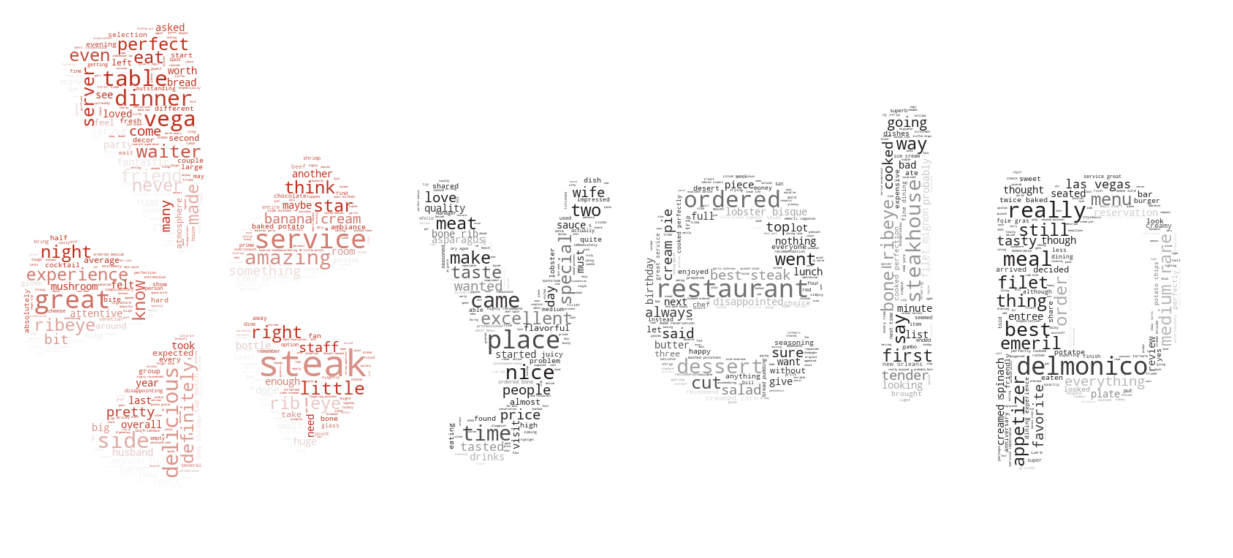

In [62]:
plt.clf()

# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(['drink', 'now', 'wine', 'flavor', 'flavors',
                  'good', 'one', 'food', 'well', 'got', 'go',
                  'better','much','back', 'us', 'will', 'ok', 'try'])

# Generate a word cloud image
mask = np.array(Image.open('/Users/jeromegonzaga/Documents/Bootcamp/Capstone Project #1_assets/yelp.png'))
wordcloud = WordCloud(stopwords=stopwords, background_color="white", mode="RGBA", 
                      max_font_size = 50, max_words=5000, mask=mask).generate(lower_review_text)

# create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[25,10])
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis('off')

plt.show()

## WordCloud used to determine what are the most frequent categories listed

In [63]:
categories_text = ' '.join(review for review in df_business_subset.categories)
    
lower_categories_text = categories_text.lower()

<Figure size 432x288 with 0 Axes>

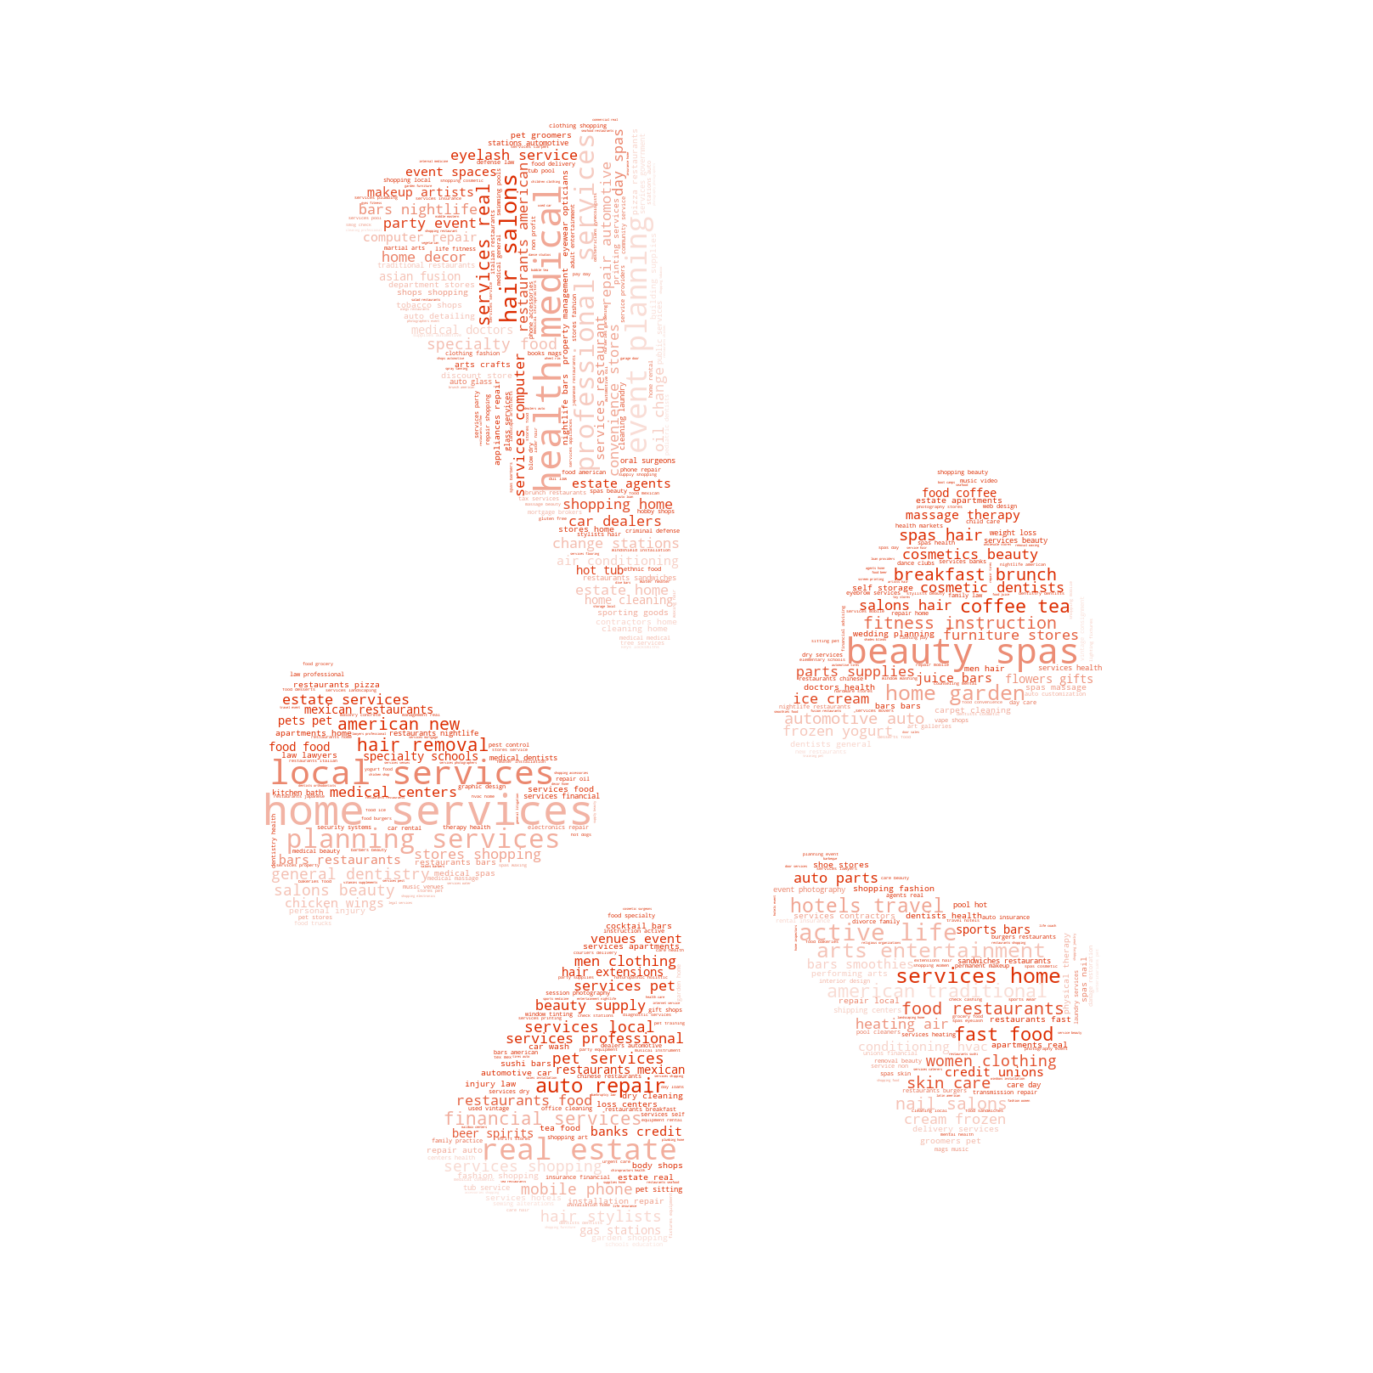

In [64]:
plt.clf()

# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(['now', 'wine', 'flavor', 'flavors',
                  'good', 'one', 'well', 'got', 'go',
                  'better','much','back', 'us', 'will', 'ok', 'try'])

# Generate a word cloud image
mask = np.array(Image.open('/Users/jeromegonzaga/Documents/Bootcamp/Capstone Project #1_assets/yelp_logo.png'))
wordcloud = WordCloud(stopwords=stopwords, background_color="white", mode="RGBA", 
                      max_font_size = 100, max_words=500, mask=mask).generate(lower_categories_text)

# create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[25,25])
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis('off')

plt.show()